# Proyecto II: Aprendizaje no supervisado

<strong>Estudiante:</strong> Mónica Gabriela Cabañas Meléndez 

### Importación de librerías necesarias

In [400]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

""" Factorización no negativa de matrices """
from sklearn.decomposition import NMF

## I. Sistema de recomendación

### Importación de datos

Los siguientes datos provienen de la base de datos de MovieLens que fue recuperada por el grupo de investigación GroupLens de la Universidad de Minesotta. Esta consiste en lo siguiente:
- 65,535 calificaciones de películas que van del 1 al 5 y que han sido realizadas por 943 usuarios. 
- Por cada usuario se tiene información demográfica básica (edad, género, ocupación, y código postal)

In [401]:
ratings = pd.read_excel(
    'data/u_data_ratings.xls', 
)

print('Cantidad de ratings: ', len(ratings))
ratings.head()

Cantidad de ratings:  65535


,User ID,Item ID,Rating,Unnamed: 3
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [402]:
genres = pd.read_excel(
    'data/u_movies_genre.xls', 
    header=None,
    names=['data'],
)

print('Cantidad de géneros: ', len(genres))
genres.head()

Cantidad de géneros:  19


,data
0,unknown|0
1,Action|1
2,Adventure|2
3,Animation|3
4,Children's|4


In [403]:
items = pd.read_excel(
    'data/u_movies_items.xls', 
    header=None,
    names=['data'],
)

print('Cantidad de películas: ', len(items))
items.head()

Cantidad de películas:  1682


,data
0,1|Toy Story (1995)|01-Jan-1995||http://us.imdb...
1,2|GoldenEye (1995)|01-Jan-1995||http://us.imdb...
2,3|Four Rooms (1995)|01-Jan-1995||http://us.imd...
3,4|Get Shorty (1995)|01-Jan-1995||http://us.imd...
4,5|Copycat (1995)|01-Jan-1995||http://us.imdb.c...


In [404]:
occupations = pd.read_excel(
    'data/u_occupation.xls', 
    header=None,
    names=['data'],
)

print('Cantidad de ocupaciones: ', len(occupations))
occupations.head()

Cantidad de ocupaciones:  21


,data
0,administrator
1,artist
2,doctor
3,educator
4,engineer


In [405]:
users = pd.read_excel(
    'data/u_user_info.xls', 
    header=None,
    names=['data'], 
)

print('Cantidad de usuarios: ', len(users))
users.head()

Cantidad de usuarios:  943


,data
0,1|24|M|technician|85711
1,2|53|F|other|94043
2,3|23|M|writer|32067
3,4|24|M|technician|43537
4,5|33|F|other|15213


Como podemos observar, algunos archivos (en específico users, items, y genres) contienen todos los datos en una sola columna separados por el caracter '|' por lo cual se procederá a realizar una transformación de estos datos para obtener matrices con las que podamos trabajar.

In [406]:
# Convirtiendo la información a cadena de texto y luego separando por el caracter '|'
if 'data' in users:
    users[['Id', 'Age', 'Sex', 'Occupation', 'Zip Code']] = users["data"].str.split(pat="|", expand=True)

    # Eliminando la columna 'data'
    users.drop('data', axis='columns', inplace=True)

# Convirtiendo a entero la columna 'Id'
if users['Id'].dtype != 'int':
    users['Id'] = users['Id'].astype(int)

In [407]:
print('Cantidad de usuarios: ', len(users))
users.head()

Cantidad de usuarios:  943


,Id,Age,Sex,Occupation,Zip Code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [408]:
# Convirtiendo la información a cadena de texto y luego separando por el caracter '|'
if 'data' in genres: 
    genres[['Name', 'Id']] = genres["data"].str.split(pat="|", expand=True)
    
    # Eliminando la columna 'data'
    genres.drop('data', axis='columns', inplace=True)
    genres = genres[['Id', 'Name']]

# Convirtiendo a entero la columna 'Id'
if genres['Id'].dtype != 'int':
    genres['Id'] = genres['Id'].astype(int)

In [409]:
print('Cantidad de géneros: ', len(genres))
genres.head()

Cantidad de géneros:  19


,Id,Name
0,0,unknown
1,1,Action
2,2,Adventure
3,3,Animation
4,4,Children's


In [410]:
# Convirtiendo la información a cadena de texto y luego separando por el caracter '|'
if 'data' in items:
        items[[
                'Id', 
                'Title', 
                'Release Date', 
                'Link', 
                'Genre 0', 
                'Genre 1', 
                'Genre 2', 
                'Genre 3', 
                'Genre 4', 
                'Genre 5', 
                'Genre 6', 
                'Genre 7', 
                'Genre 8', 
                'Genre 9', 
                'Genre 10', 
                'Genre 11', 
                'Genre 12', 
                'Genre 13', 
                'Genre 14', 
                'Genre 15', 
                'Genre 16', 
                'Genre 17', 
                'Genre 18']
        ] = items["data"].str.split(pat="\\|+", expand=True)

        # Eliminando la columna 'data'
        items.drop('data', axis='columns', inplace=True)

if items['Id'].dtype != 'int':
        items['Id'] = items['Id'].astype(int)

In [411]:
print('Cantidad de películas: ', len(items))
items.head()

Cantidad de películas:  1682


,Id,Title,Release Date,Link,Genre 0,Genre 1,Genre 2,Genre 3,Genre 4,Genre 5,...,Genre 9,Genre 10,Genre 11,Genre 12,Genre 13,Genre 14,Genre 15,Genre 16,Genre 17,Genre 18
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### Análisis de los usuarios

Procederemos a analizar descriptivamente los datos, en específico los correspondientes a la tabla de usuario. Ya que estos cuentan con variables categóricas como el sexo y la ocupación, iniciaremos tranformando el campo de las edades que es esencialmente numérico a algo categórico para facilitar el análisis y la agrupación; esto se logra clasificando a cada usuario en uno de los siguientes grupos: Niños (0, 11), Adolescentes (12, 18), Jóvenes (19, 30), Adultos (31, 60), y Tercera edad (61, infinito).

In [412]:
# Delimitando las edades a pocas categorías a fin de simplificar el análisis
bins = [-1, 11, 18, 30, 60, np.inf]                                         # Límites de edad
labels = ['Niños', 'Adolescentes', 'Jóvenes', 'Adultos', 'Tercera edad']    # Etiquetas

# Convertir 'Age' a numérico y aplicar pd.cut para clasificar edades
if 'Age' in users:
    users['Age Group'] = pd.cut(users['Age'].astype(int), bins=bins, labels=labels, right=True)

users

,Id,Age,Sex,Occupation,Zip Code,Age Group
0,1,24,M,technician,85711,Jóvenes
1,2,53,F,other,94043,Adultos
2,3,23,M,writer,32067,Jóvenes
3,4,24,M,technician,43537,Jóvenes
4,5,33,F,other,15213,Adultos
...,...,...,...,...,...,...
938,939,26,F,student,33319,Jóvenes
939,940,32,M,administrator,02215,Adultos
940,941,20,M,student,97229,Jóvenes
941,942,48,F,librarian,78209,Adultos


#### Eliminación de ruido

Se quiere encontrar una relación entre las características de los usuarios y sus gustos en las películas por lo cual debemos eliminar usuarios que no han calificado un mínimo de películas para que el análisis no sufra de ruido. 

In [413]:
# Encontrando usuarios que han calificado como mínimo 20 películas
if users.shape[0] == 943:
    print('Total de usuarios: ', users.shape[0])

# Contabilizando y filtrando usuarios en base a la cantidad de películas que han calificado
user_ratings = pd.merge(ratings, users, left_on='User ID', right_on='Id', how='inner')
user_ratings = user_ratings.groupby('User ID')['Rating'].agg('count')
users = users.loc[user_ratings[user_ratings > 20].index - 1, :]
users.index.name = None

users = users.reset_index(drop=True) # Reiniciar índices

print('Cantidad de usuarios que han calificado al menos 20 películas: ', users.shape[0])

Total de usuarios:  943
Cantidad de usuarios que han calificado al menos 20 películas:  671


#### Presentación de gráficas por cada variable categórica

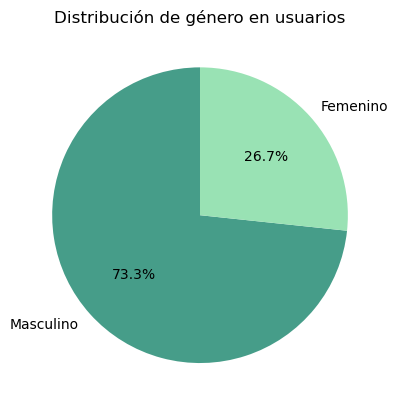

In [414]:
sex_labels = ['Masculino', 'Femenino']
sex_values = [(users['Sex'] == 'M').sum(), (users['Sex'] == 'F').sum()]

# Gráfico de pastel para género
plt.pie(x=sex_values, labels=sex_labels, autopct='%1.1f%%', startangle=90, colors=['#469D89', '#99E2B4'])
plt.title('Distribución de género en usuarios')
plt.show()

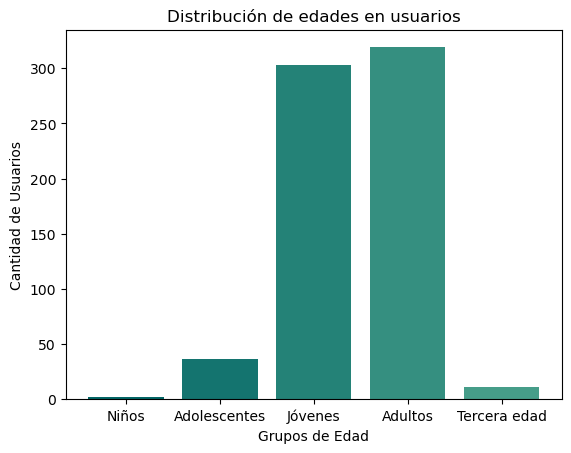

In [415]:
age_labels = ['Niños', 'Adolescentes', 'Jóvenes', 'Adultos', 'Tercera edad']
age_values = [
    (users['Age Group'] == 'Niños').sum(),
    (users['Age Group'] == 'Adolescentes').sum(),
    (users['Age Group'] == 'Jóvenes').sum(),
    (users['Age Group'] == 'Adultos').sum(),
    (users['Age Group'] == 'Tercera edad').sum()
]

# Gráfico de barras para edades
plt.bar(age_labels, age_values, color=['#036666', '#14746F', '#248277', '#358F80', '#469D89'])
plt.title('Distribución de edades en usuarios')
plt.xlabel('Grupos de Edad')
plt.ylabel('Cantidad de Usuarios')
plt.show()

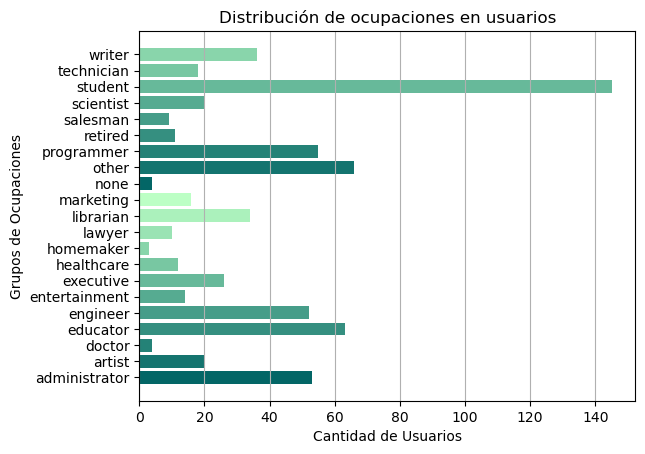

In [416]:
occupation_labels = list(occupations['data'])
occupation_values = [users['Occupation'].value_counts().get(label, 0) for label in occupation_labels]

# Gráfico de barras para ocupaciones
plt.barh(occupation_labels, occupation_values, color=['#036666', '#14746F', '#248277', '#358F80', '#469D89', '#56AB91', 
                                                      '#67B99A', '#78C7A2', '#89D5AB', '#9AE3B4', '#ABF1BC', '#BCFFC5'])
plt.title('Distribución de ocupaciones en usuarios')
plt.ylabel('Grupos de Ocupaciones')
plt.xlabel('Cantidad de Usuarios')
plt.grid(axis='x')

plt.show()

<div class="alert alert-warning">
Conclusiones:

- Sexo: la mayoría son de sexo masculino y la minoría de sexo femenino.
- Grupo de edad: la mayoría se concentra entre los jóvenes y adultos mientras que la minoría se encuentra en el grupo de los niños, adolescentes, y los adultos mayores.
- Ocupación: los estudiantes son la gran mayoría en este caso de estudio.
</div>

### Análisis de las películas y géneros

A continuación analizaremos cuáles son los géneros de películas más populares, y qué géneros prefieren los usuarios.

<b>1. Distribución de películas por géneros</b>

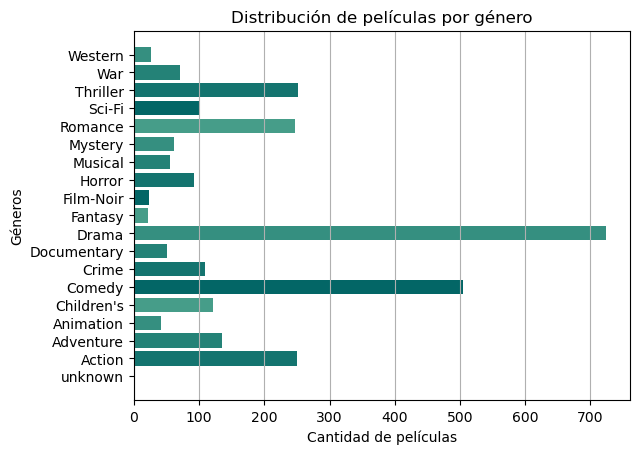

In [417]:
genres_items = []
# Contando la cantidad de películas por género
for i in range(19):
    genres_items.append(items.value_counts('Genre ' + str(i)).get('1', 0))

genres['items'] = genres_items

# Gráfico de barras para géneros y películas
plt.barh(genres['Name'], genres['items'], color=['#036666', '#14746F', '#248277', '#358F80', '#469D89'])
plt.title('Distribución de películas por género')
plt.xlabel('Cantidad de películas')
plt.ylabel('Géneros')
plt.grid(axis='x')
plt.show()

<b>2. Géneros preferidos según el sexo</b>

In [418]:
# Distribución de sexo en géneros
result = items.merge(ratings, left_on='Id', right_on='Item ID', how='inner').merge(users, left_on='User ID', right_on='Id', how='inner')
only_m = result[result['Sex'] == 'M']
only_w = result[result['Sex'] == 'F']

# Contando la cantidad de ratings dados por mujeres por cada género
genre_w = []
for i in range(19):
    genre_w.append(only_w.value_counts('Genre ' + str(i)).get('1', 0))

# Contando la cantidad de ratings dados por hombres por cada género
genre_m = []
for i in range(19):
    genre_m.append(only_m.value_counts('Genre ' + str(i)).get('1', 0))

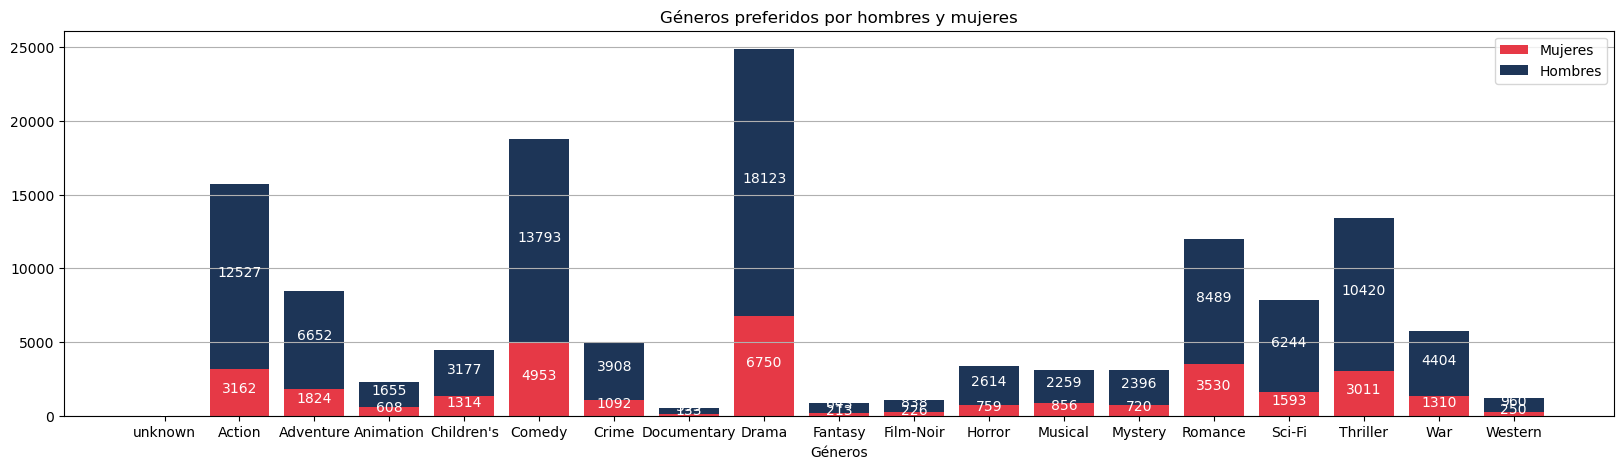

In [419]:
# Gráfico de barras para géneros y sexos
fig = plt.figure(figsize=(20, 5))
ancho_barras = np.arange(len(genres['Name']))

plt.bar(genres['Name'], genre_w, color='#e63946')
plt.bar(genres['Name'], genre_m, bottom=genre_w, color='#1d3557')
plt.legend(['Mujeres', 'Hombres'])
plt.title('Géneros preferidos por hombres y mujeres')
plt.xlabel('Géneros')
plt.grid(axis='y')

# Añadir etiquetas de valor en las barras
for i in range(len(genres['Name'])):
    # Etiqueta en la mitad de la barra de Mujeres
    plt.text(ancho_barras[i], genre_w[i] / 2, str(genre_w[i]), ha='center', color='white')
    
    # Etiqueta en la mitad de la barra de Hombres (encima de Mujeres)
    plt.text(ancho_barras[i], genre_w[i] + genre_m[i] / 2, str(genre_m[i]), ha='center', color='white')


plt.show()

<b>3. Géneros preferidos según el grupo de edad</b>

In [420]:
# Distribución de edades en géneros
kids = result[result['Age Group'] == 'Niños']
teens = result[result['Age Group'] == 'Adolescentes']
young = result[result['Age Group'] == 'Jóvenes']
adults = result[result['Age Group'] == 'Adultos']
elderly = result[result['Age Group'] == 'Tercera edad']

# Contando la cantidad de ratings dados por niños por cada género
genre_k = []
for i in range(19):
    genre_k.append(teens.value_counts('Genre ' + str(i)).get('1', 0))

# Contando la cantidad de ratings dados por adolescentes por cada género
genre_t = []
for i in range(19):
    genre_t.append(kids.value_counts('Genre ' + str(i)).get('1', 0))

# Contando la cantidad de ratings dados por jóvenes por cada género
genre_y = []
for i in range(19):
    genre_y.append(young.value_counts('Genre ' + str(i)).get('1', 0))

# Contando la cantidad de ratings dados por adultos por cada género
genre_a = []
for i in range(19):
    genre_a.append(adults.value_counts('Genre ' + str(i)).get('1', 0))

# Contando la cantidad de ratings dados por adultos por cada género
genre_e = []
for i in range(19):
    genre_e.append(elderly.value_counts('Genre ' + str(i)).get('1', 0))

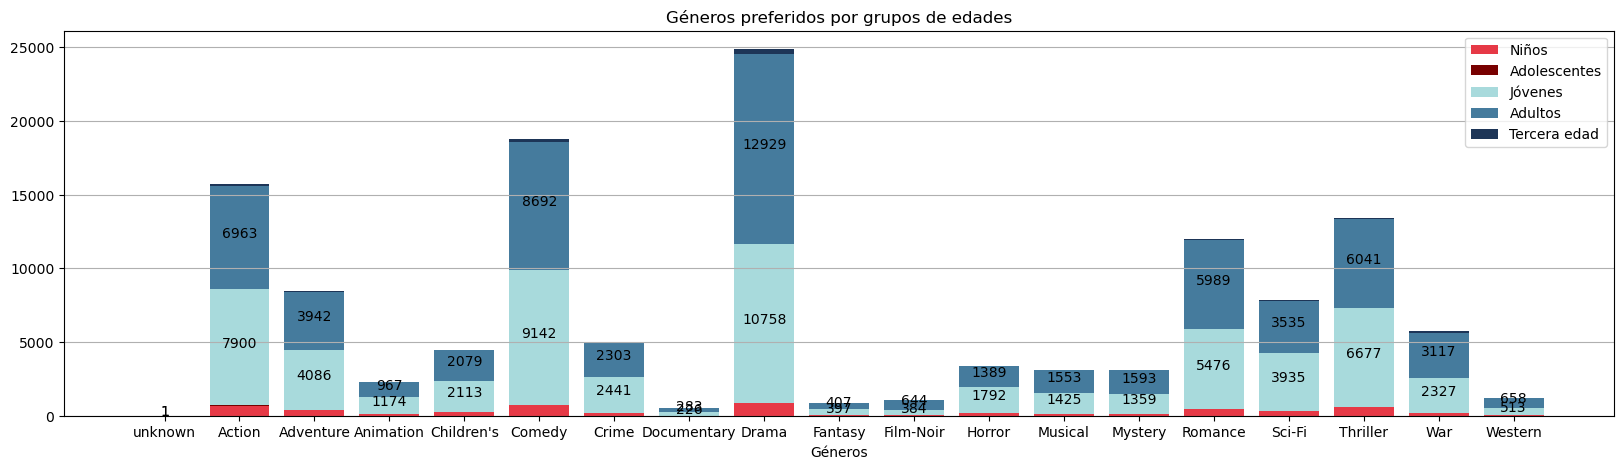

In [421]:
# Gráfico de barras para géneros y sexos
fig = plt.figure(figsize=(20, 5))
ancho_barras = np.arange(len(genres['Name']))

plt.bar(genres['Name'], genre_k, color='#e63946')
plt.bar(genres['Name'], genre_t, bottom=genre_k, color='#780000')
plt.bar(genres['Name'], genre_y, bottom=np.array(genre_k) + np.array(genre_t), color='#a8dadc')
plt.bar(genres['Name'], genre_a, bottom=np.array(genre_k) + np.array(genre_t) + np.array(genre_y), color='#457b9d')
plt.bar(genres['Name'], genre_e, bottom=np.array(genre_k) + np.array(genre_t) + np.array(genre_y) + np.array(genre_a), color='#1d3557')
plt.legend(['Niños', 'Adolescentes', 'Jóvenes', 'Adultos', 'Tercera edad'])
plt.title('Géneros preferidos por grupos de edades')
plt.xlabel('Géneros')
plt.grid(axis='y')

# Añadir etiquetas de valor en las barras apiladas
for i in range(len(genres['Name'])):
    # Etiqueta en la barra de Jóvenes
    plt.text(ancho_barras[i], genre_k[i] + genre_t[i] + genre_y[i] / 2, str(genre_y[i]), ha='center', color='black')
    
    # Etiqueta en la barra de Adultos
    plt.text(ancho_barras[i], genre_k[i] + genre_t[i] + genre_y[i] + genre_a[i] / 2, str(genre_a[i]), ha='center', color='black')
    
plt.show()

<div class="alert alert-warning">
Conclusiones

- Distribución de películas por género: gran parte de las películas corresponden a los géneros de drama y comedia.
- Géneros preferidos por mujeres y hombres: tanto los hombres como las mujeres tienen una preferencia por el género de drama.
- Géneros preferidos según el grupo de edad: tanto adultos y jóvenes (los grupos mayoritarios) tienen un gusto por el drama. Los géneros de animación, para niños, aventura, horror, ciencia ficción, y otros más, los jóvenes tienden a consumirlo con mayor frecuencia que los adultos; sin embargo, los géneros con mayor seriedad como los de guerra, misterio, y películas del viejo oeste son más consumidas por los adultos.
</div>

#### ¿Cuál género prefiere cada usuario?

Para realizar un análisis más profundo incluiremos en la tabla de usuarios la columna: 'Genre' que corresponderá al género más consumido por cada usuario, que puede representar al usuario en términos de su género preferido y de esta manera realizar clustering a partir de estos datos.

In [422]:
# Inicializar la columna 'Genre' con ceros
users['Genre'] = 0

# Iterar sobre los usuarios en el DataFrame 'users'
for i in range(users.shape[0]):
    genre_users = []  # Reiniciar la lista de géneros para cada usuario
     
    # Iterar sobre los géneros (de 0 a 18)
    for j in range(19):
        # Obtener cuántas veces el usuario ha visto el género 'j'
        genre_count = result[result['User ID'] == users['Id'].iloc[i]]['Genre ' + str(j)].value_counts().get('1', 0)
        genre_users.append(genre_count)
    
    # Encontrar el índice del género más visto
    index = genre_users.index(max(genre_users))
    
    # Asignar el índice del género más visto a la columna 'Genre' de 'users'
    users.at[i, 'Genre'] = index

In [423]:
# Obteniendo los nombres de géneros y asignándolos a los usuarios
users = users.merge(genres, left_on='Genre', right_on='Id', how='inner')[['Age Group', 'Sex', 'Occupation', 'Name']]
print('Usuarios con género favorito asignado')
users.columns = ['Age Group', 'Sex', 'Occupation', 'Genre']
users

Usuarios con género favorito asignado


,Age Group,Sex,Occupation,Genre
0,Jóvenes,M,technician,Drama
1,Adultos,F,other,Drama
2,Jóvenes,M,writer,Thriller
3,Adultos,F,other,Comedy
4,Adultos,M,executive,Drama
...,...,...,...,...
666,Adultos,M,engineer,Drama
667,Adultos,M,librarian,Drama
668,Jóvenes,M,student,Action
669,Jóvenes,M,technician,Comedy


### Transformación de variables categóricas
Procederemos ahora a realizar la tranformación de los datos categóricos a numéricos para que estos puedan ser procesados por los algoritmos de procesamiento, en específico el de KMeans. Para eso existen varias técnicas, entre algunas de ellas se encuentran:

#### 1. Category encoding
Este término es general y abarca cualquier técnica que transforme categorías no numéricas (como "rojo", "verde", "azul") en valores numéricos que los modelos puedan procesar.
Este método puede ser contraproducente cuando se aplica en categorías no ordinales dado que introduce un enfoque de ordenamiento que no es representativo. 

#### 2. One-hot encoding
Cada categoría se transforma en una columna binaria (0 o 1) separada. Este método evita el problema de asignar un valor ordinal a categorías que no tienen un orden lógico. Se crea una matriz de 0s y 1s en la que cada fila tiene un único 1, y el resto son 0s. Sin embargo, cunado se quiere utilizar algoritmos que aplican la distancia euclidiana como KMeans este método de codificación no es muy beneficioso dado que al calcular la distancia euclideana entre dos valores siempre será la misma: $ \sqrt{2} = 1.41$

Para el caso de 3 posibles categorías: $ (1, 0, 0), (0, 1, 0) $
$$
    \sqrt{(1-0)^{2} + (0-1)^2 + (0-0)^2} = \sqrt{2} = 1.41
$$

Para el caso de 5 posibles categorías: $ (1, 0, 0, 0, 0), (0, 1, 0, 0, 0) $
$$
    \sqrt{(1-0)^{2} + (0-1)^2 + (0-0)^2 + (0-0)^2 + (0-0)^2} = \sqrt{2} = 1.41
$$

#### 3. One-over-n-hot encoding
Este método es una extensión del anterior que igualmente utiliza vectores pero en vez de asignar un 1 en el índice de la categoría correspondiente se asigna un valor entre 0 y 1 que corresponde a $\frac{1}{n}$ y de esta manera cuando se hace el cálculo de la distancia euclidiana los resultados no serán los mismos para categorías con distintos posibles valores.

Para el caso de 3 posibles categorías: $ (0.33, 0, 0), (0, 0.33, 0) $
$$
    \sqrt{(0.33-0)^{2} + (0-0.33)^2 + (0-0)^2} = 0.47
$$

Para el caso de 5 posibles categorías: $ (0.2, 0, 0, 0, 0), (0, 0.2, 0, 0, 0) $
$$
    \sqrt{(0.2-0)^{2} + (0-0.2)^2 + (0-0)^2 + (0-0)^2 + (0-0)^2} = 0.28
$$

#### 4. Equal interval encoding
Este método se puede utilizar para casos en que se traten de variables categóricas que tienen un ordenamiento subyacente como es el caso de la altura, grupos de edades, entre otros. En general, los valores asignados pueden ser calculados de la siguiente manera: 

$$
\frac{i}{(n+1)}
$$

Siendo $ i $ el índice asignado a la categoría acorde al ordenamiento subyacente. Por ejemplo, para tres posibles alturas:
- 'pequeño' = $\frac{1}{(3+1)} = 0.25$
- 'medio' = $\frac{2}{(3+1)} = 0.50$
- 'alto' = $\frac{3}{(3+1)} = 0.75$

<b>1. Ocupación</b>
</br>
Iniciaremos con la variable de ocupaciones que cuenta con 21 posibilidades independientes entre sí y dado que se utilizará KMeans como algoritmo de agrupamiento utilizaremos one-over-n-hot encoding.

In [424]:
# Aplicamos One-hot encoding a la columna 'Occupation'
if 'Occupation' in users:
    users = pd.get_dummies(users, columns=['Occupation'], dtype=float)

# Obteniendo el número de columnas generadas por get_dummies
num_occupations = users.filter(like='Occupation_').shape[1]

# Sustituyendo los valores 1 por 1/num_occupations y así aplicando One-over-n-hot encoding
for i in users[users == 1].stack().index:
    users.loc[i] = (float) (1/num_occupations)

users

,Age Group,Sex,Genre,Occupation_administrator,Occupation_artist,Occupation_doctor,Occupation_educator,Occupation_engineer,Occupation_entertainment,Occupation_executive,...,Occupation_marketing,Occupation_none,Occupation_other,Occupation_programmer,Occupation_retired,Occupation_salesman,Occupation_scientist,Occupation_student,Occupation_technician,Occupation_writer
0,Jóvenes,M,Drama,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.047619,0.000000
1,Adultos,F,Drama,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,Jóvenes,M,Thriller,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.047619
3,Adultos,F,Comedy,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.047619,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,Adultos,M,Drama,0.0,0.0,0.0,0.0,0.000000,0.0,0.047619,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,Adultos,M,Drama,0.0,0.0,0.0,0.0,0.047619,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
667,Adultos,M,Drama,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
668,Jóvenes,M,Action,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.047619,0.000000,0.000000
669,Jóvenes,M,Comedy,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.047619,0.000000


<b>2. Géneros </b>
</br>
Al igual que con las ocupaciones se utilizará one-over-n-hot encoding, sin embargo, no se utilizará la totalidad de géneros ya que en los procesos anteriores se asignó a cada usuario únicamente el género que más consume, por lo tanto algunos géneros no aparecen si no únicamente el que representa el gusto del usuario.

In [425]:
if 'Genre' in users:
    users = pd.get_dummies(users, columns=['Genre'], dtype=float)

num_genres = users.filter(like='Genre_').shape[1]

# Sustituyendo los valores 1 por 1/num_genres y así aplicando One-over-n-hot encoding
for i in users[users == 1].stack().index:
    users.loc[i] = (float) (1/num_genres)

users

,Age Group,Sex,Occupation_administrator,Occupation_artist,Occupation_doctor,Occupation_educator,Occupation_engineer,Occupation_entertainment,Occupation_executive,Occupation_healthcare,...,Occupation_technician,Occupation_writer,Genre_Action,Genre_Adventure,Genre_Children's,Genre_Comedy,Genre_Drama,Genre_Horror,Genre_Romance,Genre_Thriller
0,Jóvenes,M,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.047619,0.000000,0.000,0.0,0.0,0.000,0.125,0.0,0.0,0.000
1,Adultos,F,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000,0.0,0.0,0.000,0.125,0.0,0.0,0.000
2,Jóvenes,M,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.047619,0.000,0.0,0.0,0.000,0.000,0.0,0.0,0.125
3,Adultos,F,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000,0.0,0.0,0.125,0.000,0.0,0.0,0.000
4,Adultos,M,0.0,0.0,0.0,0.0,0.000000,0.0,0.047619,0.0,...,0.000000,0.000000,0.000,0.0,0.0,0.000,0.125,0.0,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
666,Adultos,M,0.0,0.0,0.0,0.0,0.047619,0.0,0.000000,0.0,...,0.000000,0.000000,0.000,0.0,0.0,0.000,0.125,0.0,0.0,0.000
667,Adultos,M,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.000,0.0,0.0,0.000,0.125,0.0,0.0,0.000
668,Jóvenes,M,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.125,0.0,0.0,0.000,0.000,0.0,0.0,0.000
669,Jóvenes,M,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,...,0.047619,0.000000,0.000,0.0,0.0,0.125,0.000,0.0,0.0,0.000


<b>3. Sexo</b>
</br>
Para el caso del sexo que es una variable binaria aplicaremos un caso especial de one-over-n-hot encoding: <b>Attenuated one-over-n-hot encoding</b> el cual explica James McCafrrey en el siguiente artículo: <a href="https://visualstudiomagazine.com/Articles/2024/05/15/clustering-mixed-categorical-and-numeric-data.aspx">Clustering Mixed Categorical and Numeric Data Using k-Means with C#</a> que en varios experimentos la sola aplicación de one-over-n-hot encoding en variables binarias no se ha comportado tan bien como con attenuated encoding: <em>"In some experiments, the plain one-over-n-hot encoding for binary categorical data did not work as well as the attenuated encoding. But results were not conclusive and how best to encode binary categorical data is an open research question."</em>

Aplicando attenuated encoding en el sexo las categorías se sustituirían de la siguiente manera: 
- M = 0.5
- F = 0.0

In [426]:
for i in users[users == 'M'].stack().index:
    users.loc[i] = 0.5

for i in users[users == 'F'].stack().index:
    users.loc[i] = 0.0

users.head()

,Age Group,Sex,Occupation_administrator,Occupation_artist,Occupation_doctor,Occupation_educator,Occupation_engineer,Occupation_entertainment,Occupation_executive,Occupation_healthcare,...,Occupation_technician,Occupation_writer,Genre_Action,Genre_Adventure,Genre_Children's,Genre_Comedy,Genre_Drama,Genre_Horror,Genre_Romance,Genre_Thriller
0,Jóvenes,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.047619,0.000000,0.0,0.0,0.0,0.000,0.125,0.0,0.0,0.000
1,Adultos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000,0.125,0.0,0.0,0.000
2,Jóvenes,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.047619,0.0,0.0,0.0,0.000,0.000,0.0,0.0,0.125
3,Adultos,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.125,0.000,0.0,0.0,0.000
4,Adultos,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.0,...,0.000000,0.000000,0.0,0.0,0.0,0.000,0.125,0.0,0.0,0.000


<b>4. Grupo de edades</b>
</br>
En procesos anteriores se dividió a los usuarios en 5 grupos: niños, adolescentes, jóvenes, adultos y tercera edad, por lo cual estamos hablando de una variable categórica. Para este caso se trata de una variable que tiene intrínseco un orden por lo cual utilizaremos equal interval encoding.

In [427]:
# Aplicamos One-hot encoding a la columna 'Age Group'
if 'Age Group' in users:
    users = pd.get_dummies(users, columns=['Age Group'], dtype=float)

# Obteniendo el número de columnas generadas por get_dummies
num_age_groups = users.filter(like='Age Group_').shape[1]

users.loc[users['Age Group_Niños'] == 1, 'Age Group_Niños']               = 1/(num_age_groups+1)
users.loc[users['Age Group_Adolescentes'] == 1, 'Age Group_Adolescentes'] = 2/(num_age_groups+1)
users.loc[users['Age Group_Jóvenes'] == 1, 'Age Group_Jóvenes']           = 3/(num_age_groups+1)
users.loc[users['Age Group_Adultos'] == 1, 'Age Group_Adultos']           = 4/(num_age_groups+1)
users.loc[users['Age Group_Tercera edad'] == 1, 'Age Group_Tercera edad'] = 5/(num_age_groups+1)


# Sustituyendo los valores 1 por 1/num_age_groups y así aplicando One-over-n-hot encoding
""" for i in users[users == 1].stack().index:
    users.loc[i] = 1/num_age_groups """

users.head()

,Sex,Occupation_administrator,Occupation_artist,Occupation_doctor,Occupation_educator,Occupation_engineer,Occupation_entertainment,Occupation_executive,Occupation_healthcare,Occupation_homemaker,...,Genre_Comedy,Genre_Drama,Genre_Horror,Genre_Romance,Genre_Thriller,Age Group_Niños,Age Group_Adolescentes,Age Group_Jóvenes,Age Group_Adultos,Age Group_Tercera edad
0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000,0.125,0.0,0.0,0.000,0.0,0.0,0.5,0.000000,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000,0.125,0.0,0.0,0.000,0.0,0.0,0.0,0.666667,0.0
2,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000,0.000,0.0,0.0,0.125,0.0,0.0,0.5,0.000000,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.125,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.666667,0.0
4,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.047619,0.0,0.0,...,0.000,0.125,0.0,0.0,0.000,0.0,0.0,0.0,0.666667,0.0


### Estadísticas de los datos

In [428]:
# Obteniendo estadísticas de los datos
users.describe()

,Occupation_administrator,Occupation_artist,Occupation_doctor,Occupation_educator,Occupation_engineer,Occupation_entertainment,Occupation_executive,Occupation_healthcare,Occupation_homemaker,Occupation_lawyer,...,Genre_Comedy,Genre_Drama,Genre_Horror,Genre_Romance,Genre_Thriller,Age Group_Niños,Age Group_Adolescentes,Age Group_Jóvenes,Age Group_Adultos,Age Group_Tercera edad
count,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,...,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000,671.000000
mean,0.003761,0.001419,0.000284,0.004471,0.003690,0.000994,0.001845,0.000852,0.000213,0.000710,...,0.020119,0.077496,0.001304,0.001118,0.006148,0.000497,0.017884,0.225782,0.316940,0.013661
std,0.012853,0.008104,0.003668,0.013900,0.012742,0.006811,0.009197,0.006316,0.003179,0.005774,...,0.045970,0.060719,0.012710,0.011776,0.027051,0.009092,0.075165,0.249010,0.333178,0.105898
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.125000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.666667,0.000000
max,0.047619,0.047619,0.047619,0.047619,0.047619,0.047619,0.047619,0.047619,0.047619,0.047619,...,0.125000,0.125000,0.125000,0.125000,0.125000,0.166667,0.333333,0.500000,0.666667,0.833333


Como podemos observar en la tabla anterior, existe una gran acumulación de datos en las medias. Esto puede afectar negativamente al modelo con KMeans porque algunos clusters que estén poco representados no serán reconocidos por el modelo y los obviara, por ello estandarizaremos los datos para que estos tengan una media de 0 y una desviación estándar de 1.

In [429]:
from sklearn.preprocessing import StandardScaler
standarized_users = StandardScaler().fit_transform(users)

### Visualización de datos utilizando PCA

Procederemos a visualizar los datos y cómo se encuentran dispersos en el espacio. Sin embargo, como se tratan de datos de gran dimensionalidad utilizamos PCA para reducir la dimensionalidad y de esta manera facilitar la visualización.

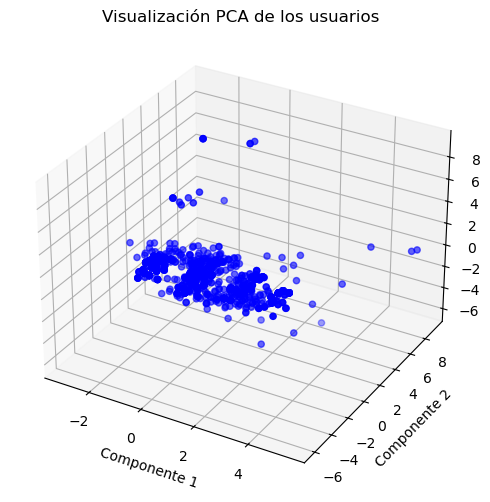

In [430]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Reducir a 3 dimensiones
pca = PCA(n_components=3)
pca_components = pca.fit_transform(standarized_users)

# Obtener los puntos únicos y contar las ocurrencias de cada punto
unique_points, counts = np.unique(pca_components, axis=0, return_counts=True)

# Graficar los resultados en 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Usamos 'counts' como el tamaño de las burbujas
#bubble_size = counts * 10  # Ajusta el multiplicador para controlar el tamaño

# Graficar burbujas
ax.scatter(unique_points[:, 1], unique_points[:, 2], unique_points[:, 0], 
        c='blue', alpha=0.6)

ax.scatter(pca_components[:, 0], pca_components[:, 1], pca_components[:, 2], c='blue')
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
ax.set_title('Visualización PCA de los usuarios')
plt.show()

### Definición óptima de K

Utilizaremos el método del codo y la silueta para determinar el número de grupos óptimo para este set de datos. ¿Por qué no se utiliza únicamente el coeficiente de la silueta? Si el coeficiente de la silueta aumenta continuamente a medida que se incrementa k, no es necesariamente bueno. Puede significar que los datos se están dividiendo en demasiados clusters pequeños, lo que no refleja una segmentación significativa (Lo cual sucede en este set de datos). Al utilizar ambos contrastamos los resultados para escoger el mejor número de clusters: tanto visualizando el punto de inflexión en el método del codo y verificando que el coeficiente de la silueta sea mayor a 0.

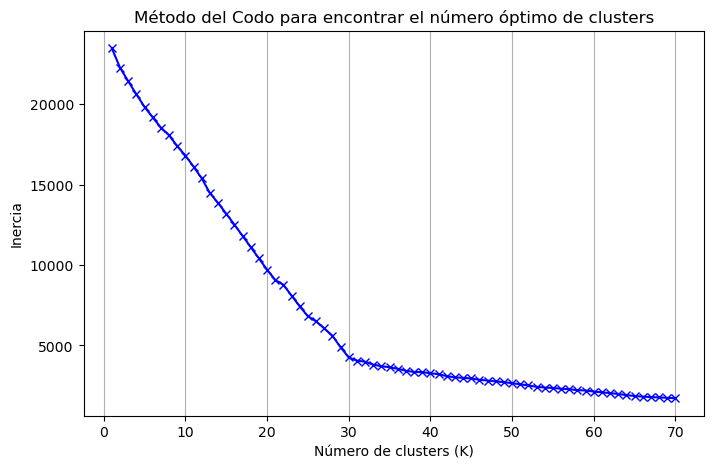

In [431]:
from sklearn.cluster import KMeans

# Función para encontrar el número óptimo de clusters
def elbow_method(X, max_clusters=10):
    inertia = []
    K = range(1, max_clusters+1)

    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
        kmeans.fit(X)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(8, 5))
    plt.plot(K, inertia, 'bx-')
    plt.xlabel('Número de clusters (K)')
    plt.ylabel('Inercia')
    plt.title('Método del Codo para encontrar el número óptimo de clusters')
    plt.grid(axis='x')
    plt.show()

elbow_method(standarized_users, 70)

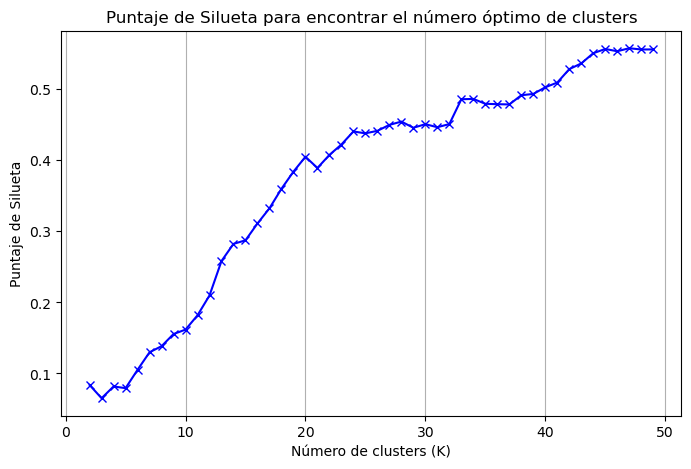

In [432]:
from sklearn.metrics import silhouette_score

def get_silhoutte_chart(X, max_clusters=10):

    silhouette_scores = []
    for i in range(2, max_clusters):
        kmeans = KMeans(n_clusters=i, n_init='auto', random_state=0).fit(X)
        silhouette_scores.append(silhouette_score(X, kmeans.labels_))

    plt.figure(figsize=(8, 5))
    plt.plot(range(2, 50), silhouette_scores, 'bx-')
    plt.xlabel('Número de clusters (K)')
    plt.ylabel('Puntaje de Silueta')
    plt.title('Puntaje de Silueta para encontrar el número óptimo de clusters')
    plt.grid(axis='x')
    plt.show()

get_silhoutte_chart(standarized_users, 50)

### NMF

A continuación crearemos la matriz $V$ que estará compuesta por la combinación de los usuarios con las películas y las calificaciones serán los valores de cada celda. Cada usuario será una observación y cada película una característica.

In [433]:
user_rating_counts = ratings['User ID'].value_counts()
print('Cantidad de usuarios con ratings: ', user_rating_counts.shape)

Cantidad de usuarios con ratings:  (916,)


In [434]:
item_rating_counts = ratings['Item ID'].value_counts()
print('Cantidad de películas con ratings: ', item_rating_counts.shape)

Cantidad de películas con ratings:  (1626,)


No todas las películas han sido calificadas y no todos los usuarios han calificado por lo cual hay que indicar esos valores vacíos con algo representativo. En este caso indicaremos los valores vacíos con $-1$ para luego sustituirlos por otro valor arbitrario con el cual podamos iniciar NMF.

In [435]:
# Crear la matriz usuario-película
user_movie_matrix = ratings.pivot_table(columns='Item ID', index='User ID', values='Rating', fill_value=-1)

print('Dimensiones de la matriz usuario-película: ', user_movie_matrix.shape)
user_movie_matrix.head()

Dimensiones de la matriz usuario-película:  (916, 1626)


Item ID,1,2,3,4,5,6,7,8,9,10,...,1655,1656,1657,1658,1660,1661,1662,1663,1664,1669
User ID,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,-1.0,3.0,3.0,5.0,-1.0,1.0,5.0,3.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,4.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


#### Eliminando ruido

Existen muchos usuarios que no han votado como mínimo 20 películas y algunas películas que no han sido votadas por al menos 10 usuarios, por lo cual eliminaremos dichos elementos del dataset para evitar ruido en el mismo. En las siguientes gráficas podremos observar los elementos que están por debajo de la línea roja no cumplen con el mínimo establecido (20 películas calificadas por usuario y que una película haya sido calificada por lo menos por 10 usuarios).

In [436]:
movies_votes_counts = ratings.groupby('Item ID')['Rating'].agg('count')
user_votes_counts = ratings.groupby('User ID')['Rating'].agg('count')

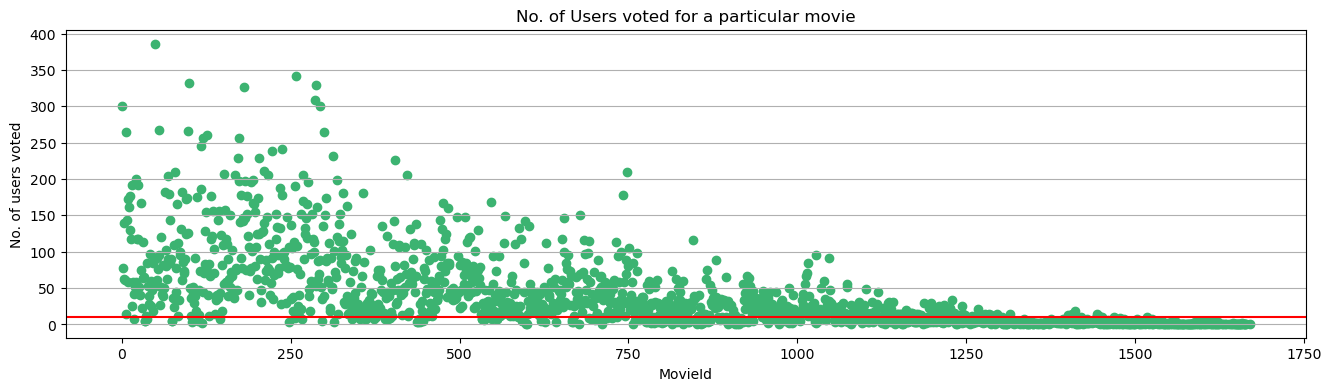

In [437]:
f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(movies_votes_counts.index, movies_votes_counts,color='mediumseagreen')
plt.axhline(y=10,color='r')
plt.xlabel('MovieId')
plt.ylabel('No. of users voted')
plt.title('No. of Users voted for a particular movie')
plt.grid(axis='y')
plt.show()

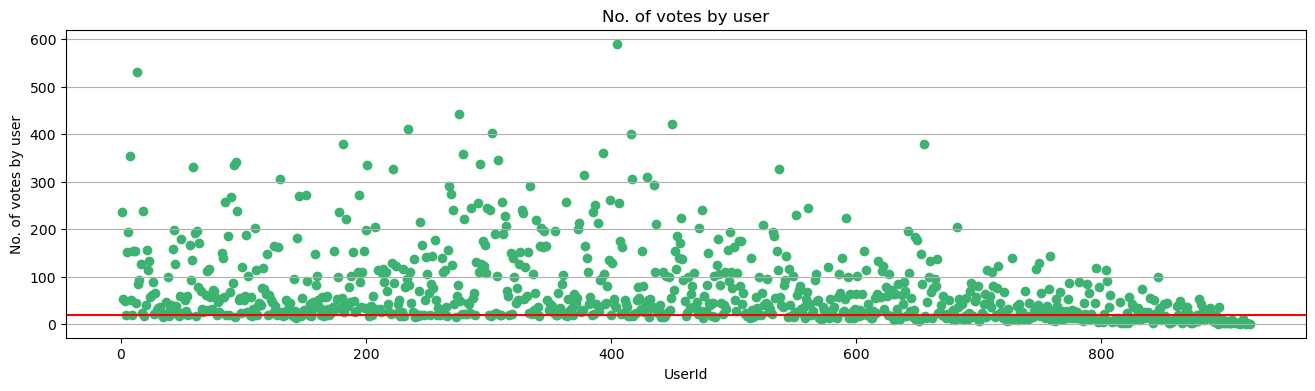

In [438]:
f,ax = plt.subplots(1,1,figsize=(16,4))
plt.scatter(user_votes_counts.index, user_votes_counts,color='mediumseagreen')
plt.axhline(y=20,color='r')
plt.xlabel('UserId')
plt.ylabel('No. of votes by user')
plt.title('No. of votes by user')
plt.grid(axis='y')
plt.show()

In [439]:
user_movie_matrix = user_movie_matrix.loc[user_votes_counts[user_votes_counts > 20].index, :]
user_movie_matrix = user_movie_matrix.loc[:, movies_votes_counts[movies_votes_counts > 10].index]
print('Dimensiones de la matriz usuario-película: ', user_movie_matrix.shape)
user_movie_matrix.head()

Dimensiones de la matriz usuario-película:  (671, 1001)


Item ID,1,2,3,4,5,6,7,8,9,10,...,1280,1283,1286,1296,1315,1401,1407,1411,1444,1446
User ID,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,-1.0,3.0,3.0,5.0,-1.0,1.0,5.0,3.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
5,4.0,3.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
6,4.0,-1.0,-1.0,-1.0,-1.0,-1.0,2.0,-1.0,4.0,-1.0,...,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


#### Variaciones de NMF: EM, WNMF y un enfoque híbrido

Ahora que hemos eliminado el ruido, antes de aplicar NMF debemos lidiar con los valores vacíos (que por el momento hemos dejado indicados como -1). En el artículo <a href="https://archive.siam.org/meetings/sdm06/proceedings/059zhangs2.pdf">Learning from Incomplete Ratings Using Non-negative Matrix Factorization</a> se describen tres variaciones de NMF que han resultado efectivas para trabajar con ratings incompletos como el de este caso:
- <b>Expectation Maximization (EM):</b> Este método estima los valores faltantes utilizando una técnica iterativa. En cada iteración, los ratings faltantes se reemplazan con las predicciones actuales, y luego se aplica NMF a la matriz completa para mejorar el modelo.

- <b>Weighted Non Negative Matrix Factorization (WNMF):</b> Introduce un factor de ponderación para los datos observados, lo que permite diferenciar entre ratings conocidos y faltantes. Aquí, las entradas conocidas tienen un peso mayor que las faltantes en el proceso de factorización.

- <b>Enfoque híbrido:</b> Combina ambos métodos, iniciando con algunas iteraciones del algoritmo EM y refinando el modelo final con WNMF. Este enfoque es más rápido y efectivo para obtener predicciones precisas, ya que evita depender de inicializaciones aleatorias que pueden afectar la calidad del modelo.

En este trabajo se ha implementado únicamente Expectation Maximization (EM).

In [440]:
def initialize_missing_values(matrix, init_value=0):
    # Reemplaza los valores faltantes (-1) con init_value
    filled_matrix = matrix.copy()
    filled_matrix[filled_matrix == -1] = init_value
    return filled_matrix

def em_nmf(matrix, n_components, max_iter=5):
    # Inicializamos los valores faltantes con 0 y aplicamos NMF con EM
    filled_matrix = initialize_missing_values(matrix, 0)
    nmf = NMF(n_components=n_components, init='random', random_state=0, max_iter=1000)

    # Aplicamos NMF iterativamente y actualizamos los valores faltantes con la estimación de NMF
    for i in range(max_iter):
        W = nmf.fit_transform(filled_matrix)
        H = nmf.components_
        estimated_matrix_em = pd.DataFrame(np.dot(W, H), columns=matrix.columns, index=matrix.index)

        filled_matrix[matrix == -1] = estimated_matrix_em[matrix == -1]

    return estimated_matrix_em, W, H

estimated_em, W, H = em_nmf(user_movie_matrix, 19)

In [441]:
W = pd.DataFrame(W, index=user_movie_matrix.index)
W

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
User ID,,,,,,,,,,,,,,,,,,,
1,0.900017,1.481001,0.452358,0.674934,0.435925,0.000000,0.000000,0.000000,0.153380,0.388331,0.480308,1.296893,0.989976,0.158329,0.405849,0.456554,0.070968,0.017411,0.658083
2,0.000000,0.000000,0.000000,1.097989,0.000000,0.000000,0.193286,0.228554,0.000000,0.000000,0.000000,0.251336,0.000000,0.150934,0.000000,0.050591,0.590846,0.049555,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.381525,0.000000,0.000000,0.036801,0.023289,0.000000,0.098756,0.230443,0.106283,0.000000,0.482024,0.090861,0.000000
5,0.000000,0.000000,1.045210,0.000000,0.580796,0.000000,0.000000,0.000000,1.405890,0.968790,0.000000,0.000000,0.699227,0.305675,0.000000,0.000000,0.000000,0.510248,0.006350
6,1.349156,0.000000,0.410872,0.324786,0.098343,1.506282,0.000000,0.031625,0.240942,0.000000,0.570757,1.231610,0.000000,0.161760,0.578311,0.000000,0.195244,0.965286,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,0.797134,0.000000,1.710672,0.000225,0.000000,0.000000,0.000000,0.155425,0.580347,0.000000,0.038851,0.000000,0.000000,0.116314,0.000000,0.187280,0.000000,0.000000,0.000000
883,0.006718,0.080551,0.000000,0.096975,0.094015,0.000000,0.000000,0.000000,0.540114,0.582197,0.000000,1.013950,0.041447,0.250435,0.000000,0.000000,0.011549,0.000000,0.055674
886,1.885995,0.000000,0.256608,0.000000,0.157983,0.000000,0.000000,0.088143,0.089733,0.000000,0.000000,0.000000,0.327873,0.000000,0.000000,0.000000,0.000000,0.000000,0.094315


In [442]:
H = pd.DataFrame(H, columns=user_movie_matrix.columns)
H

Item ID,1,2,3,4,5,6,7,8,9,10,...,1280,1283,1286,1296,1315,1401,1407,1411,1444,1446
0,0.146752,0.011106,0.078400,0.565029,0.066068,0.000000,0.565674,0.478708,0.333647,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.029166,0.063791,0.375576,0.241083,0.288187,0.005337,0.064903,0.134167,0.315638,0.234446,...,0.000000,0.000000,0.000000,0.052630,0.000000,0.038281,0.000000,0.032166,0.009616,0.000000
2,0.722806,0.027263,0.000000,0.004117,0.012922,0.000000,0.057709,0.740250,0.083920,0.000000,...,0.026055,0.000000,0.000000,0.000000,0.000000,0.028650,0.000000,0.000000,0.228659,0.000000
3,2.355865,0.000000,0.726163,0.000000,0.000000,0.610132,2.735210,0.000000,3.321509,1.479089,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.060099,0.000000,0.000000,0.000000
4,3.366166,2.310737,0.655492,1.070333,0.000000,0.000000,3.819962,0.358144,0.000000,1.208248,...,0.220573,0.000000,0.000000,0.000000,0.000000,1.072957,0.000000,2.028675,0.000000,0.511910
5,0.351405,0.000000,0.000000,0.311945,0.002504,0.148079,0.421228,0.542120,0.378891,1.029711,...,0.000000,0.000000,0.748285,0.000000,0.000000,0.171958,0.000000,0.294122,0.375840,0.071672
6,0.016059,0.000000,0.000000,0.000000,0.000000,0.036862,0.138876,0.000000,0.080667,0.000000,...,0.121605,0.000000,0.000000,0.375790,0.105099,0.000000,0.000000,0.000000,0.000000,0.000000
7,3.956486,0.167612,1.626968,0.000000,1.368157,0.000000,2.700860,0.515044,2.255690,0.732389,...,0.000000,1.523796,0.000000,0.000000,1.212701,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.191472,0.000000,0.093865,0.915048,0.000000,0.000000,0.010456,0.952529,0.041098,0.000000,...,0.000000,0.066552,0.018012,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.017305,0.013623,0.000000,0.000000,1.178991,0.000000,1.095085,0.000000,0.000000,0.001752,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.043723,0.000000


In [443]:
# Matriz reconstruida
estimated_em = pd.DataFrame(estimated_em, columns=user_movie_matrix.columns, index=user_movie_matrix.index)
estimated_em

Item ID,1,2,3,4,5,6,7,8,9,10,...,1280,1283,1286,1296,1315,1401,1407,1411,1444,1446
User ID,,,,,,,,,,,,,,,,,,,,,
1,4.652955,3.401759,2.632652,3.702223,1.910683,1.367358,5.768210,3.185597,5.342735,3.467250,...,0.385957,0.250263,0.591433,0.360234,0.419614,1.352455,0.839691,1.294625,0.188446,0.753221
2,4.111160,0.060130,1.174496,0.071190,0.346377,0.860697,3.915433,0.354844,4.323305,2.037254,...,0.652719,0.360174,0.027754,0.548642,0.305836,0.069709,0.095251,0.009180,0.015407,0.039175
3,0.861195,0.123142,0.158402,0.190172,0.076072,0.050926,0.536950,0.295049,0.229183,0.081315,...,0.701409,0.023489,0.136401,0.877871,0.241412,0.047210,0.055345,0.086074,0.019631,0.059624
5,4.143412,1.810341,1.279682,2.406226,1.383638,0.000000,3.841872,2.583847,0.262527,0.779328,...,0.297915,0.189137,0.184683,0.000000,0.015225,0.896843,0.371627,1.381159,0.382561,0.677669
6,3.386161,0.716907,0.829894,2.654973,0.194955,1.321164,3.606445,3.932034,3.993938,3.805170,...,0.240298,0.165789,1.978458,0.369743,0.575932,0.709531,0.265051,1.114815,0.851531,0.461552
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,2.425999,0.139297,0.373292,1.093388,0.401927,0.000137,1.101211,2.448375,0.930012,0.117501,...,0.044814,0.280807,0.064886,0.000000,0.213934,0.107895,0.016685,0.000000,0.411809,0.087389
883,1.512203,0.369408,0.256281,0.817098,0.755797,0.800502,1.886988,1.221956,0.895073,1.254027,...,0.041486,0.048658,0.011210,0.180062,0.000000,0.335458,0.111154,0.199743,0.026230,0.061171
886,1.437452,0.771899,0.741478,1.597815,0.398134,0.000000,2.027912,1.315611,0.955189,0.276141,...,0.108387,0.185716,0.013334,0.000000,0.106891,0.291147,0.171082,0.371322,0.058676,0.184059


Las tablas anteriores representan las matrices W, H, y la estimación de V al realizar la multiplicación de W y H. Las celdas que antes estaban vacías ahora tienen valores numéricos mayores o iguales a 0 y que pueden ser interpretados como las calificaciones estimadas que daría un usuario en caso calificara tal película; esto puede ser utilizado para recomendar las películas que el sistema estima que el usuario calificaría como mejores.

Ya que tenemos nuestro sistema de recomendaciones procederemos a realizar recomendaciones personalizadas a cada usuario basado en las calificaciones que ha dado a una serie de películas.

#### Recomendando películas a usuarios existentes en la base de datos

In [444]:
def get_recommendations(user_id, n_recommendations=10, estimated_em=estimated_em):
    # Corremos el algoritmo de NMF con EM por si se trata de un usuario recientemente registrado
    if user_id not in user_movie_matrix.index:
        print('El usuario no ha realizado ratings')
        return None
    elif user_id in user_movie_matrix.index and (user_movie_matrix.loc[user_id] == -1).any():
        estimated_matrix_em, W, H = em_nmf(user_movie_matrix, 19)
    else:
        estimated_matrix_em = estimated_em

    # Obtenemos las recomendaciones para el usuario
    movies_id = estimated_matrix_em.loc[user_id].sort_values(ascending=False).index
    movies_id = pd.DataFrame(movies_id, columns=['Item ID'])
        
    user_recommendations = movies_id.merge(items, left_on='Item ID', right_on='Id', how='inner')[['Id', 'Title', 'Release Date']].head(n_recommendations)

    return user_recommendations, estimated_matrix_em

In [445]:
# Puedes cambiar el id del usuario para obtener recomendaciones
user_id = 2
recommendations, estimated_em = get_recommendations(user_id, estimated_em=estimated_em)
recommendations

,Id,Title,Release Date
0,302,L.A. Confidential (1997),01-Jan-1997
1,268,Chasing Amy (1997),01-Jan-1997
2,269,"Full Monty, The (1997)",01-Jan-1997
3,100,Fargo (1996),14-Feb-1997
4,276,Leaving Las Vegas (1995),01-Jan-1995
5,313,Titanic (1997),01-Jan-1997
6,286,"English Patient, The (1996)",15-Nov-1996
7,340,Boogie Nights (1997),01-Jan-1997
8,50,Star Wars (1977),01-Jan-1977
9,272,Good Will Hunting (1997),01-Jan-1997


#### Recomendando películas a usuarios que no existen en la base de datos

Para realizar dicha recomendación debemos realizar las siguientes acciones:
1. Crear el usuario lo cual implica una fila con un nuevo id y rellenar todas sus celdas con -1 para indicar que no ha calificado ninguna película.
2. Obtener sus calificaciones en una serie de películas (por lo menos 20 para que tenga congruencia con el análisis realizado anteriormente) de manera aleatoria.
3. Insertar su registro en la matriz usuario-película y volver a ejecutar el algoritmo NMF en este o en este caso la variación de NMF: EM.
4. Obtener la matriz reconstruida y seleccionar su registro. A partir de este registro enlistar las películas de manera descendente en base a las calificaciones obtenidas.

In [446]:

import ipywidgets as widgets

# Seleccionar películas aleatorias para calificar
quantity = 20
random_movies_id = pd.DataFrame(np.random.choice(user_movie_matrix.columns, quantity, replace=False), columns=['Item ID'])
random_movies = random_movies_id.merge(items, left_on='Item ID', right_on='Id', how='inner')[['Id','Title', 'Release Date']]
options = [1, 2, 3, 4, 5]

# Crear widgets para calificar las películas
print('Por favor, califique las siguientes películas:')
widgets_array = []
for i in range(quantity):
    widget = widgets.Box(
        [
            widgets.Label(value='Película: ' + random_movies['Title'].loc[i]),
            widgets.RadioButtons(
                    options=options,
                )
        ]
    )
    widgets_array.append(widget)
    display(widget)

# Obtener las calificaciones de las películas
def get_user_ratings(widgets_array, movies_id):
    user_ratings = []
    for i in range(5):
        movie_rating = {
            'item_id': movies_id['Item ID'].loc[i],
            'rating': widgets_array[i].children[1].value
        }
        user_ratings.append(movie_rating)
    return user_ratings

Por favor, califique las siguientes películas:


Box(children=(Label(value='Película: Queen Margot (Reine Margot, La) (1994)'), RadioButtons(options=(1, 2, 3, …

Box(children=(Label(value="Película: Young Poisoner's Handbook, The (1995)"), RadioButtons(options=(1, 2, 3, 4…

Box(children=(Label(value='Película: Toy Story (1995)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

Box(children=(Label(value='Película: Disclosure (1994)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

Box(children=(Label(value='Película: Amadeus (1984)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

Box(children=(Label(value='Película: Four Rooms (1995)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

Box(children=(Label(value='Película: Broken Arrow (1996)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

Box(children=(Label(value='Película: Once Upon a Time in America (1984)'), RadioButtons(options=(1, 2, 3, 4, 5…

Box(children=(Label(value='Película: Postman, The (1997)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

Box(children=(Label(value='Película: Cape Fear (1962)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

Box(children=(Label(value='Película: Island of Dr. Moreau, The (1996)'), RadioButtons(options=(1, 2, 3, 4, 5),…

Box(children=(Label(value='Película: Phenomenon (1996)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

Box(children=(Label(value='Película: Star Trek: The Wrath of Khan (1982)'), RadioButtons(options=(1, 2, 3, 4, …

Box(children=(Label(value='Película: When Harry Met Sally... (1989)'), RadioButtons(options=(1, 2, 3, 4, 5), v…

Box(children=(Label(value='Película: Volcano (1997)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

Box(children=(Label(value='Película: Bonnie and Clyde (1967)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)…

Box(children=(Label(value='Película: Groundhog Day (1993)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

Box(children=(Label(value='Película: City of Lost Children, The (1995)'), RadioButtons(options=(1, 2, 3, 4, 5)…

Box(children=(Label(value='Película: Paradise Lost: The Child Murders at Robin Hood Hills (1996)'), RadioButto…

Box(children=(Label(value='Película: Malice (1993)'), RadioButtons(options=(1, 2, 3, 4, 5), value=1)))

In [447]:
user_ratings = get_user_ratings(widgets_array, random_movies_id)

# Ordenando la matriz usuario-película por 'User ID' y creando un nuevo usuario en la matriz
user_movie_matrix = user_movie_matrix.sort_values(by='User ID')
new_user_id = user_movie_matrix.index[len(user_movie_matrix) - 1] + 1
user_movie_matrix.loc[new_user_id] = -1

# Actualizando la matriz usuario-película con los ratings del usuario
for rating in user_ratings:
    user_movie_matrix.at[new_user_id, rating['item_id']] = rating['rating']

In [448]:
# Obteniendo las recomendaciones para el nuevo usuario
recommendations, estimated_em = get_recommendations(new_user_id, estimated_em=estimated_em)
print('Recomendaciones para el nuevo usuario:')
recommendations

Recomendaciones para el nuevo usuario:


,Id,Title,Release Date
0,318,Schindler's List (1993),01-Jan-1993
1,50,Star Wars (1977),01-Jan-1977
2,196,Dead Poets Society (1989),01-Jan-1989
3,423,E.T. the Extra-Terrestrial (1982),01-Jan-1982
4,1,Toy Story (1995),01-Jan-1995
5,69,Forrest Gump (1994),01-Jan-1994
6,181,Return of the Jedi (1983),14-Mar-1997
7,215,Field of Dreams (1989),01-Jan-1989
8,191,Amadeus (1984),01-Jan-1984
9,64,"Shawshank Redemption, The (1994)",01-Jan-1994


<div class="alert alert-info">
    <h2>Preguntas y respuestas</h2>

1. <b>Analisis de la información presentada. ¿Qué se puede inferir de los datos?</b>

    R// A partir de las gráficas realizadas se observó que había una acumulación de datos en ciertos grupos; por ejemplo, en el caso de los usuarios, hay mucho más hombres que mujeres, los jóvenes y los adultos son los grupos de edad predominantes, y la gran mayoría son estudiantes. En el caso de las películas, había mayor acumulación de estas en géneros de drama, comedia y acción. También cabe destacar que había una acumulación de usuarios que no habían calificado al menos 20 películas, y una gran mayoría de películas que no habían sido calificadas por lo menos por 10 usuarios, mientras que una minoría de usuarios habían calificado más de 300 películas, y muy pocas películas habían sido calificadas por más de 400 usuarios. Como se mencionó al principio, existe una acumulación de datos en ciertos grupos mientras que en otros hay muy pocos por lo cual al ejecutar algoritmos de aprendizaje en estos es muy probable que estos grupos dominantes influyan de manera negativa en el aprendizaje de estos modelos.

2. <b>Implementación y explicación del sistema de recomendación. Análisis de los resultados del sistema de recomendación utilizando un ejemplo.</b>

    R// El sistema de recomendación se implementó primeramente creando una tabla pivote a partir de la tabla de 'ratings', se eliminaron los usuarios que no habían calificado por lo menos 20 películas y las películas que no habían sido calificadas por lo menos por 10 usuarios para evitar 'ruidos' en el set de datos. Luego de esto se utilizó el método NMF de la librería scikit-learn con 19 componentes, correspondientes a la cantidad de géneros de las películas, de esta forma se pudo separar a los usuarios por los gustos que estos tenían (acción, aventura, terror, animadas, entre otros). Dado que la matriz usuario-película se trataba de calificaciones incompletas se recurrió a la variación de NMF: EM para solucionar el problema de valores vacíos y de esta manera realizar una mejor estimación. Luego, al obtener la matriz estimada se puede obtener las películas recomendadas a un usuario en particular seleccionando la fila correspondiente al ID del usuario y enlistar las películas en orden descendente, siendo las primeras las más recomendadas y las últimas las menos recomendadas. 


3. <b>¿Cómo puedo evaluar que peliculas le podrian gustar a un usuario nuevo (que no este en la base de datos) basado en las calificaciones que este da a una serie de peliculas?</b>

    R// El nuevo usuario debe ser insertado en la matriz pivote de usuario-película y luego ejecutar el algoritmo de NMF en esta nueva matriz; sin embargo, antes de que pueda ser insertado debe de calificar un mínimo de películas para que al aplicar NMF, este pueda encontrar un patrón latente entre las calificaciones de este con otros usuarios. Si se inserta este nuevo usuario con valores vacíos lo más probable es que no se obtengan buenas estimaciones al no poder encontrar similitudes con otros usuarios. Al tener ese mínimo de calificaciones por parte del usuario se procede a ejecutar el algoritmo NMF y reconstruir la matriz a partir de las W y H; esta matriz reconstruida nos dará calificaciones aproximadas que el usuario puede dar a ciertas películas a partir de las preferencias de otros usuarios con los que el algoritmo encontró relación.

4. <b>Análisis sobre como incorporar toda la información otorgada.</b>

    R// Los datos venían en archivos distintos y ni siquiera estaban separados en columnas si no en una sola cadena de texto como es el caso de las películas, los usuarios y los géneros. Se aplicaron diversas técnicas de procesamiento de datos para obtener información como la distribución de los usuarios con respecto al sexo, la edad, y la ocupación; lo mismo se realizó en el caso de las películas y los géneros, obteniendo información sobre la distribución de las películas con respecto al género y la preferencia de género de los usuarios dependiendo de su sexo, y su ocupación.

    Para realizar la agrupación a partir de KMeans en los usuarios se procesaron las variables categóricas por medio de one

5. <b>¿Qué se puede inferir sobre los diferentes usuarios y sus gustos en peliculas? se puede encontrar alguna relación entre edad, profesión, sexo y genero de peliculas que les gusta a estos grupos? ¿Cómo se podria obtener esta información?</b>

    R// 

6. <b>Durante el desarrollo de cada uno de los puntos del taller indique los métodos utilizados y explique la forma como los utiliza.</b>

7. <b>Una discusión sobre el desarrollo del proyecto, los metodos utilizados, posibles mejoras, etc..</b>
</div>

## Referencias

- https://visualstudiomagazine.com/Articles/2024/05/15/clustering-mixed-categorical-and-numeric-data.aspx
- https://jamesmccaffrey.wordpress.com/2024/04/15/clustering-categorical-data-using-k-means-with-one-over-n-hot-encoding/

## II. Cuantización de imágenes

### Monet

In [449]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io

# Utilidades para cargar y visualizar imágenes
def get_image_from_url(url):
    # Cargar la imagen desde una URL
    image = io.imread(url)
    return image

def show_image(image):
    # Mostrar la imagen
    plt.imshow(image)
    plt.axis('off')
    plt.show()

def plot_3d_image(image, name=''):
    # Crear el meshgrid para las coordenadas X e Y (posición de los píxeles)
    x = np.arange(0, image.shape[1])  # Coordenadas de ancho
    y = np.arange(0, image.shape[0])  # Coordenadas de alto
    x, y = np.meshgrid(x, y)

    # Convertir la imagen a escala de grises para usar la intensidad como Z
    z = np.mean(image, axis=2)  # Promedio de los canales RGB para la intensidad

    # Crear la figura 3D
    fig = plt.figure(figsize=(18, 16))
    ax = fig.add_subplot(111, projection='3d')

    # Graficar los puntos (píxeles) en 3D con la intensidad como eje Z
    ax.scatter(x, y, z, c=image.reshape(-1, 3)/255.0, s=10)
    ax.set_xlabel('Coordenada X')
    ax.set_ylabel('Coordenada Y')
    ax.set_zlabel('Color component')
    ax.set_title('Visualización 3D de la imagen: ' + name)
    plt.show()

def plot_2d_data(data, title='', xlabel='', ylabel=''):
    # Crear la figura 2D
    plt.figure(figsize=(12, 6))
    plt.scatter(data[:,0], data[:,1], c=data[:,2], cmap='viridis')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

def plot_3d_data(data, title='', xlabel='', ylabel='', zlabel=''):
    # Crear la figura 3D
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Graficar los puntos en 3D
    ax.scatter(data[:,0], data[:,1], data[:,2], c=data[:,2], cmap='viridis')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_zlabel(zlabel)
    ax.set_title(title)
    plt.show()

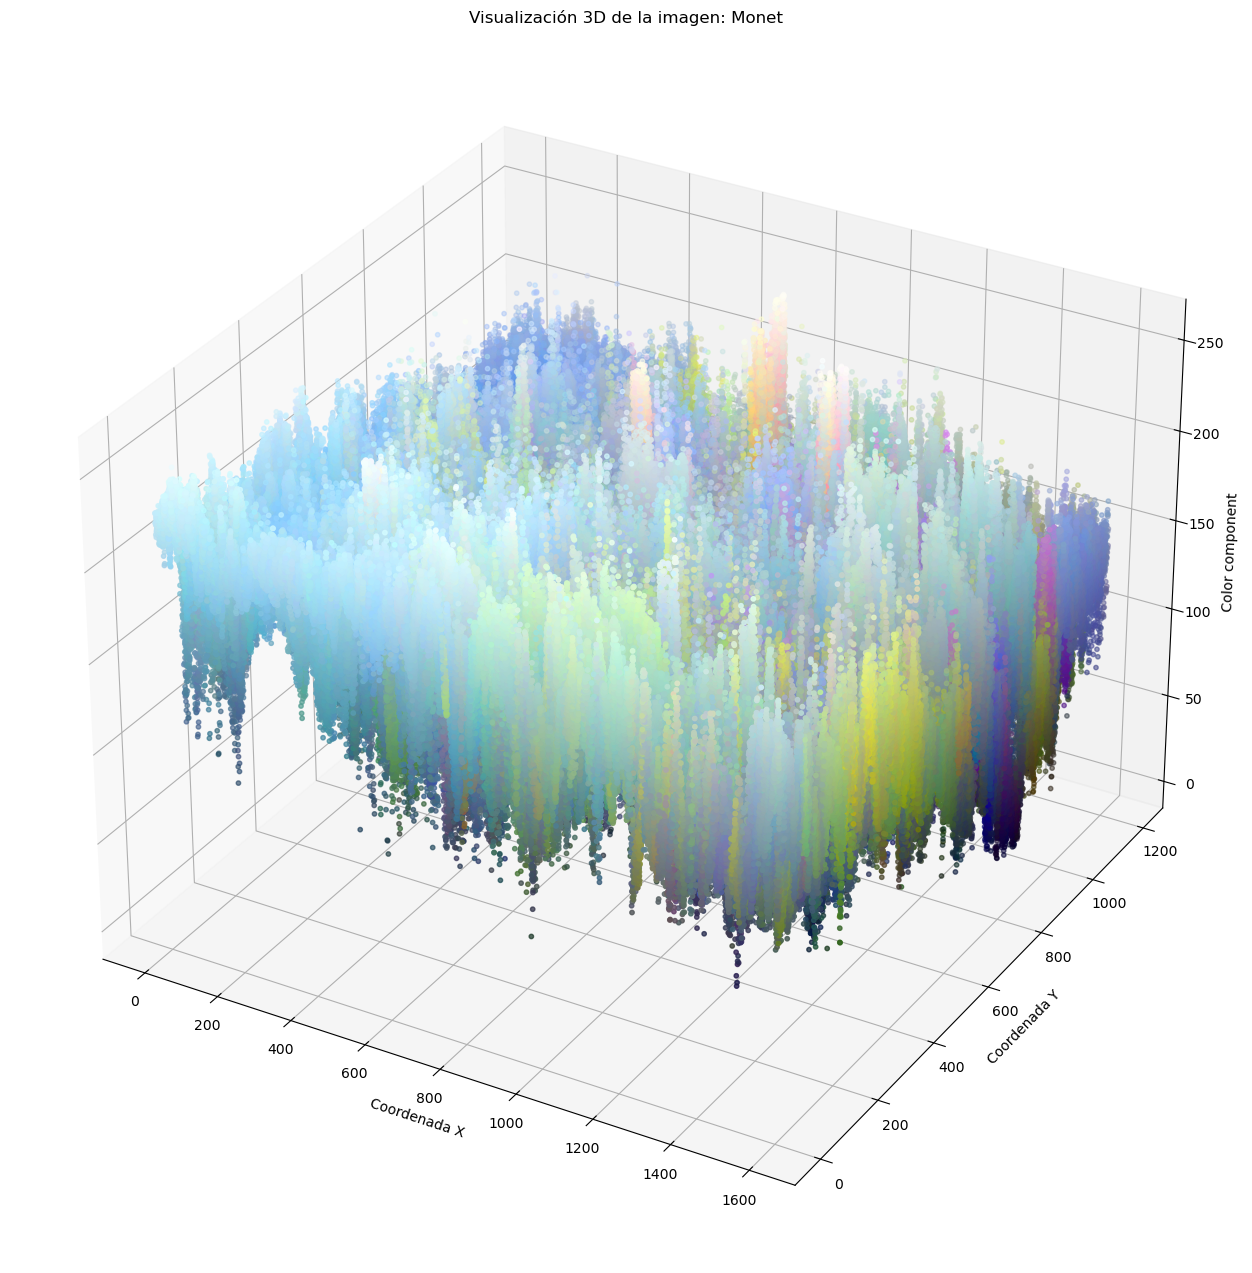

In [450]:
image = get_image_from_url('Paintings/Monet.jpg')
plot_3d_image(image, 'Monet')

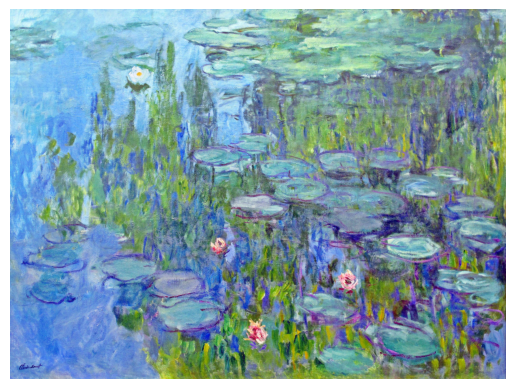

In [451]:
show_image(image)

El gráfico anterior es una representación en 3D de la imagen donde las coordenadas X e Y representan la posición del pixel en la imagen y la coordenada Z representa la intensidad del color en una escala de grises. En la escala de grises que va de 0 a 255, si un color es cercano a 0 significa que este es más oscuro a comparación de otro que sea más cercano a 255. 

A continuación se reduce la dimensión de la imagen, pasando de 3 a 2 dimensiones. Cada fila representa un píxel y cada columna un canal de color RGB (Rojo, Verde, y Azul)

In [452]:
# Convertir la imagen a una matriz de dos dimensiones (píxeles, canales de color)
image = image / 255.0
pixels = image.reshape(-1, 3)
pixels = pd.DataFrame(pixels, columns=['Red', 'Green', 'Blue'])
print('Cantidad de píxeles en la imagen: ', pixels.shape[0])
pixels

Cantidad de píxeles en la imagen:  1908800


,Red,Green,Blue
0,0.752941,0.898039,0.960784
1,0.721569,0.874510,0.941176
2,0.709804,0.870588,0.941176
3,0.733333,0.901961,0.976471
4,0.756863,0.925490,0.992157
...,...,...,...
1908795,0.509804,0.611765,0.741176
1908796,0.490196,0.560784,0.701961
1908797,0.517647,0.549020,0.701961
1908798,0.501961,0.490196,0.666667


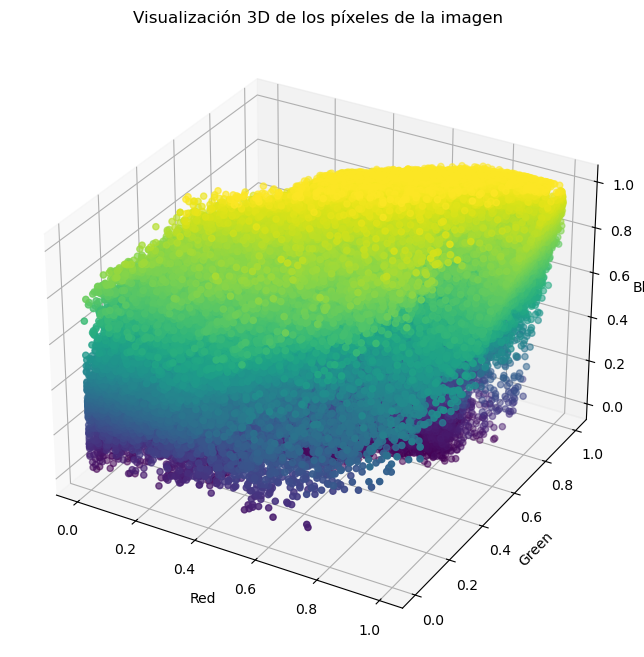

In [453]:
plot_3d_data(pixels.values, 'Visualización 3D de los píxeles de la imagen', 'Red', 'Green', 'Blue')

In [454]:
from sklearn.cluster import KMeans

# Definir el número de clusters (colores deseados)
num_clusters = 15

# Aplicar K-means
kmeans = KMeans(n_clusters=num_clusters, n_init='auto', random_state=0)
kmeans.fit(pixels)

# Obtener los colores medios y las etiquetas de cada cluster
colors = kmeans.cluster_centers_
labels = kmeans.labels_

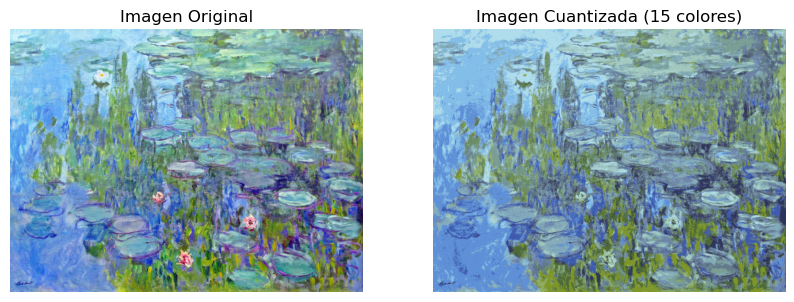

In [455]:
import matplotlib.pyplot as plt

# Reemplazar cada píxel con el color del cluster al que pertenece
quantized_image = colors[labels].reshape(image.shape)

# Mostrar la imagen original y la imagen cuantizada
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Imagen original
ax[0].imshow(image)
ax[0].set_title('Imagen Original')
ax[0].axis('off')

# Imagen cuantizada
ax[1].imshow(quantized_image)
ax[1].set_title(f'Imagen Cuantizada ({num_clusters} colores)')
ax[1].axis('off')

plt.show()